In [1]:
import sys 
sys.path.append('r/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm')
from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import jax
from jax import vmap, jit
from flax import linen as nn
import matplotlib.pyplot as plt # creating visualizations
from functools import partial

### Generate Data

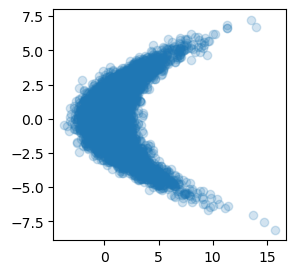

In [2]:
def generate_data_curved(key, n_samples):
  keys = jr.split(key, 2)
  epsilon = jr.normal(keys[0], shape=(n_samples, ))
  x_data = jr.uniform(keys[1], (n_samples, ), minval=-10.5, maxval=10.5)
  y_data = 7*jnp.sin(0.75*x_data) + 0.5*x_data + epsilon
  return jnp.array([x_data, y_data])

def generate_data_nl_gaussian(key, n_samples):
  keys = jr.split(key, 2)
  u  = jr.normal(keys[0], shape=(n_samples, 2))
  x = 2 * u[:, 0]
  y = x ** 2 / 4 + u[:, 1]
  return jnp.array([y, x])

def generate_circular_data(key, n_samples):
  keys = jr.split(key, 2)
  u = jr.uniform(keys[0], (n_samples, ))
  u1 = 0.1 * jr.normal(keys[1], (n_samples, 2))
  x = 2 * jnp.cos(2 * jnp.pi * u) + u1[:, 0]
  y = 2 * jnp.sin(2 * jnp.pi * u) + u1[:, 1]
  return jnp.array([x, y])

  
n_samples = batch_size = 10000 # just use train everything in a batch
data = generate_data_nl_gaussian(jr.PRNGKey(0), n_samples).T
# data = data[:, ::-1]
# x_data = jnp.array(x_data.reshape(batch_size, 1))
# y_data = jnp.array(y_data.reshape(batch_size, 1))

# plot the original data and the test data
plt.figure(figsize=(3, 3))
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.show()

### MADE dev (introduce order-agnostic training)

### Training

In [3]:
import optax
from inference import MADE, MADE2

# MLP contains 2 Linear layers, 1 Dropout layer, 1 BatchNorm layer
key1, key2 = jr.split(jr.PRNGKey(0))
din = 2
dcond = 0
dhidden = 16
nhidden = 1
model = MADE2(din, dhidden, nhidden, dcond, nnx.Rngs(0), False, True, False, False)
learning_rate = 0.01
momentum = 0.9
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

@nnx.jit  # automatic state management
def train_step(model, optimizer, data):
  loss_fn = lambda model: model.loss_fn(data)
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates
  return loss

losses = []
num_epochs = 3 * 1000
minibatch_size = 100
keys = jr.split(key1, num_epochs)
for i in range(num_epochs):
  loss = train_step(model, optimizer, data)
  losses.append(loss)
  if i % 100 == 0:
    print(f'Iteration {i}, Loss {loss}')

Iteration 0, Loss 21.925992965698242
Iteration 100, Loss 3.720350742340088
Iteration 200, Loss 3.6190714836120605
Iteration 300, Loss 3.5880181789398193
Iteration 400, Loss 3.5649561882019043
Iteration 500, Loss 3.549156665802002
Iteration 600, Loss 3.5398952960968018
Iteration 700, Loss 3.5347793102264404
Iteration 800, Loss 3.5316479206085205
Iteration 900, Loss 3.5298421382904053
Iteration 1000, Loss 3.5288195610046387
Iteration 1100, Loss 3.528308868408203
Iteration 1200, Loss 3.5280284881591797
Iteration 1300, Loss 3.5278115272521973
Iteration 1400, Loss 3.527559280395508
Iteration 1500, Loss 3.5274100303649902
Iteration 1600, Loss 3.527331829071045
Iteration 1700, Loss 3.527231216430664
Iteration 1800, Loss 3.5271568298339844
Iteration 1900, Loss 3.527113199234009
Iteration 2000, Loss 3.5270674228668213
Iteration 2100, Loss 3.5269951820373535
Iteration 2200, Loss 3.5269510746002197
Iteration 2300, Loss 3.5269052982330322
Iteration 2400, Loss 3.5268568992614746
Iteration 2500, Los

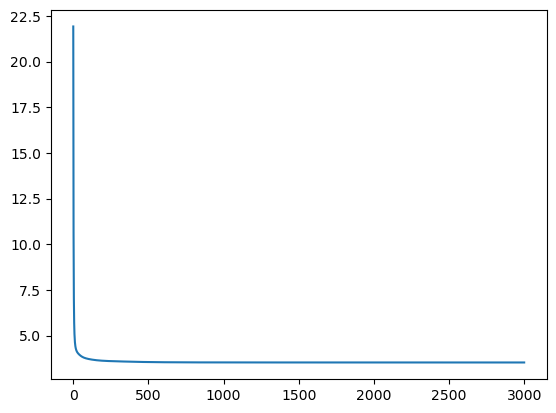

In [4]:
plt.plot(losses)
plt.show()

### Evaluation

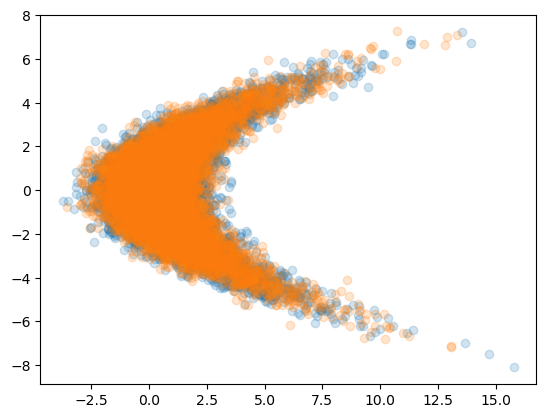

In [5]:
model.eval()
num_samples = 10000
samples = model.generate(jr.PRNGKey(0), num_samples, data[:, :dcond])
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.scatter(samples[:, 0], samples[:,1], alpha=0.2)
plt.show()

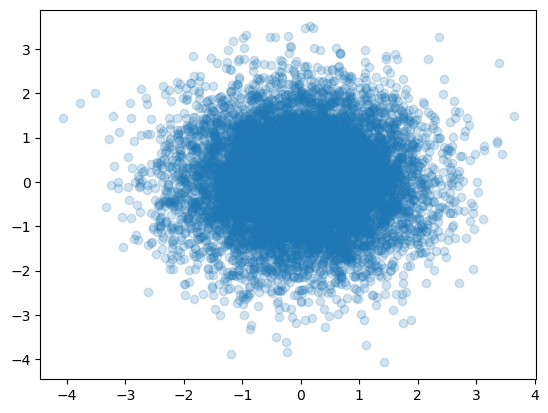

In [6]:
out, alphas = model(data)
us = out[:, dcond:]
if dcond == 1:
  plt.hist(us[:,0], bins=100, alpha=0.5)
else:
    plt.scatter(us[:,0], us[:,1], alpha=0.2)
plt.show()

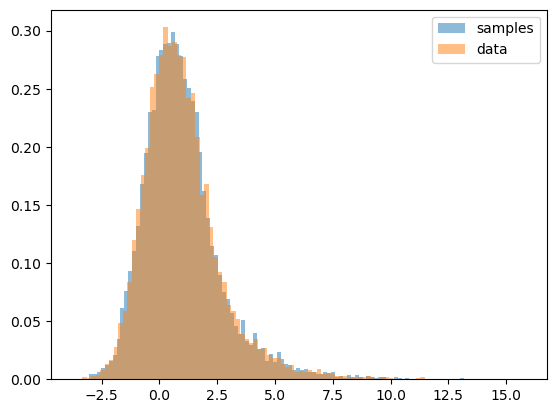

In [7]:
plt.hist(samples[:,0], bins=100, alpha=0.5, label='samples', density=True)
plt.hist(data[:,0], bins=100, alpha=0.5, label='data', density=True)
plt.legend()
plt.show()